### Colab Specific

In [1]:
!cp /content/drive/MyDrive/senior_ds_test.zip .

In [2]:
!unzip senior_ds_test.zip

Archive:  senior_ds_test.zip
   creating: senior_ds_test/
   creating: senior_ds_test/.ipynb_checkpoints/
   creating: senior_ds_test/data/
   creating: senior_ds_test/data/.ipynb_checkpoints/
   creating: senior_ds_test/data/final_submission/
  inflating: senior_ds_test/data/final_submission/sample_submission.csv  
   creating: senior_ds_test/data/test/
  inflating: senior_ds_test/data/test/accounts_data_test.json  
  inflating: senior_ds_test/data/test/enquiry_data_test.json  
  inflating: senior_ds_test/data/test/test_flag.csv  
   creating: senior_ds_test/data/train/
  inflating: senior_ds_test/data/train/accounts_data_train.json  
  inflating: senior_ds_test/data/train/enquiry_data_train.json  
  inflating: senior_ds_test/data/train/train_flag.csv  
  inflating: senior_ds_test/problem_statement.pdf  


### Load Library and Data

In [3]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier,plot_importance

In [4]:
def read_json(file_path):
  with open(file_path) as f:
    tmp = json.load(f)
  l = [pd.DataFrame(data) for data in tmp]
  df = pd.concat(l,ignore_index=True,sort=False)
  return df

In [5]:
sub = pd.read_csv('senior_ds_test/data/final_submission/sample_submission.csv')

accounts_data_train = read_json('senior_ds_test/data/train/accounts_data_train.json')
enquiry_data_train = read_json('senior_ds_test/data/train/enquiry_data_train.json')
train_flag = pd.read_csv('senior_ds_test/data/train/train_flag.csv')

accounts_data_test = read_json('senior_ds_test/data/test/accounts_data_test.json')
enquiry_data_test = read_json('senior_ds_test/data/test/enquiry_data_test.json')
test_flag = pd.read_csv('senior_ds_test/data/test/test_flag.csv')

### Data understanding & Preparation

In [ ]:
accounts_data_train.shape,accounts_data_train['uid'].nunique()

((1245310, 7), 223918)

In [ ]:
accounts_data_train.head(1)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.0,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550


In [ ]:
#some uid doesn't have accounts_data_train, so they can be new customers
train_flag[~train_flag['uid'].isin(accounts_data_train['uid'])].head()

,uid,NAME_CONTRACT_TYPE,TARGET
4,WJZ68772744,Cash loans,0
7,DBK56652751,Cash loans,1
13,VJY65237599,Cash loans,0
25,CDR05672029,Cash loans,0
27,GYL79147955,Cash loans,1


In [ ]:
#some uid doesn't have accounts_data_train, so they can be new customers
train_flag['TARGET'][~train_flag['uid'].isin(accounts_data_train['uid'])].value_counts(normalize=1)

0    0.898572
1    0.101428
Name: TARGET, dtype: float64

In [ ]:
enquiry_data_train.groupby(['uid']).agg({'enquiry_type':'nunique'}).reset_index().sort_values(by='enquiry_type',ascending=False).head()

,uid,enquiry_type
53889,FJQ51514651,17
57488,FSW73151740,17
208325,USM18365186,17
181198,SAD05487757,17
219540,VVB28407158,17


In [ ]:
train_flag.shape,train_flag['uid'].nunique()

((261383, 3), 261383)

In [ ]:
test_flag.shape,test_flag['uid'].nunique()

((46127, 2), 46127)

In [ ]:
accounts_data_train.isna().sum()

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

In [ ]:
enquiry_data_train.shape,enquiry_data_train['uid'].nunique()

((1909926, 4), 261383)

In [ ]:
set(enquiry_data_train['enquiry_type']).issuperset(enquiry_data_test['enquiry_type'])

True

In [ ]:
set(accounts_data_train['credit_type']).issuperset(accounts_data_test['credit_type'])

True

In [ ]:
set(enquiry_data_train['enquiry_type']).issuperset(accounts_data_train['credit_type'])

True

In [ ]:
train_flag['TARGET'].value_counts(normalize=1)

0    0.91944
1    0.08056
Name: TARGET, dtype: float64

In [ ]:
sorted()

### Data Preparation

In [6]:
def count_bad_payment(payment_hist_string):
  count = 0
  for i in range(0,len(payment_hist_string),3):
    val = int(payment_hist_string[i:i+3])
    if val > 7:
      count += 1
  return count

# Assuming more than 1 week Late as Fatal Late Payment,i.e, not due to forgetting payment date, technical issue etc.
accounts_data_train['count_late_payment'] = accounts_data_train['payment_hist_string'].apply(count_bad_payment)

In [7]:
accounts_data_train['open_date'] = pd.to_datetime(accounts_data_train['open_date'])
accounts_data_train['closed_date'] = pd.to_datetime(accounts_data_train['closed_date'])

### Fill Null values : closed_date = open_date + payment_duration
accounts_data_train['closed_date'] = np.where(accounts_data_train['closed_date'].isna(),
                                              accounts_data_train[['open_date','payment_hist_string']].apply(lambda x: x[0] + pd.DateOffset(months=len(x[1])//3),axis=1),
                                              accounts_data_train['closed_date'])
accounts_data_train['loan_duration'] = (accounts_data_train['closed_date'] - accounts_data_train['open_date']).dt.days

In [8]:
### Make all credit type in columns and fill values with count of rows for each uid
credit_type_count = pd.crosstab(accounts_data_train['uid'],accounts_data_train['credit_type']).reset_index()
### UID level for amount variables
credit_amounts = accounts_data_train.groupby(['uid']).agg({'loan_amount':['sum','min','max','count'],
                                                     'amount_overdue':['sum','min','max','count'],
                                                     'count_late_payment':['sum','min','max','count'],
                                                     'loan_duration':['sum','min','max','count']}).reset_index()
credit_amounts.columns = credit_amounts.columns.map('_'.join)
credit_amounts.rename(columns={'uid_':'uid'},inplace=True)

In [9]:
uid_level = pd.merge(credit_type_count,credit_amounts,how='inner',on=['uid'])
### Merge with Train_Flag
uid_level = pd.merge(uid_level,train_flag,how='inner',on=['uid'])
uid_level.fillna(0,inplace=True)
uid_level = pd.get_dummies(uid_level,columns=['NAME_CONTRACT_TYPE']) #Only categorcial column
uid_level.isna().sum().sum()

0

In [10]:
enquiry_type_count = pd.crosstab(enquiry_data_train['uid'],enquiry_data_train['enquiry_type']).reset_index()
enquiry_amt = enquiry_data_train.groupby(['uid']).agg({'enquiry_amt':['sum','min','max','count']}).reset_index()
enquiry_amt.columns = enquiry_amt.columns.map('_'.join)
enquiry_amt.rename(columns={'uid_':'uid'},inplace=True)
enquiry = pd.merge(enquiry_type_count,enquiry_amt,how='inner',on=['uid'])
enquiry.fillna(0,inplace=True)
enquiry.isna().sum().sum()

0

In [11]:
uid_level_old = uid_level.copy()

In [12]:
uid_level = pd.merge(uid_level,enquiry,how='right',on=['uid'],suffixes=('_account','_enquiry'))


In [13]:
uid_level.fillna(0,inplace=True)

### EDA

In [ ]:
for col in uid_level.columns:
  if uid_level[col].nunique() < 50:
    tmp = pd.crosstab(uid_level[col],uid_level['TARGET']).reset_index()
    tmp['Total_Loan'] = tmp[0] + tmp[1]
    tmp['Total_Loan_Dist'] = 100*tmp['Total_Loan']/tmp['Total_Loan'].sum()
    tmp['bad_loan_ratio'] = 100*tmp[1]/tmp['Total_Loan']
    tmp['bad_loan_dist'] = 100*tmp[1]/tmp[1].sum()
    tmp['good_loan_dist'] = 100*tmp[0]/tmp[0].sum()
    display(tmp)
  else:
    try:
      tmp = uid_level.groupby(['TARGET']).agg({col:'describe'}).reset_index()
      display(tmp)
    except:
      print(col)

TARGET     uid                          
           count  unique          top freq
0      0  206661  206661  AAA09044550    1
1      1   17257   17257  AAB67762691    1

TARGET,Another type of loan,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206015,17205,223220,99.688279,7.707643,99.698673,99.687411
1,1,620,51,671,0.299663,7.600596,0.295532,0.300008
2,2,21,1,22,0.009825,4.545455,0.005795,0.010162
3,3,3,0,3,0.001340,0.000000,0.000000,0.001452
4,4,2,0,2,0.000893,0.000000,0.000000,0.000968


TARGET,Car loan,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,190974,16294,207268,92.564242,7.861320,94.419656,92.409308
1,1,12971,818,13789,6.158058,5.932265,4.740105,6.276462
2,2,2175,126,2301,1.027608,5.475880,0.730138,1.052448
3,3,426,17,443,0.197840,3.837472,0.098511,0.206135
4,4,83,1,84,0.037514,1.190476,0.005795,0.040162
5,5,23,1,24,0.010718,4.166667,0.005795,0.011129
6,6,5,0,5,0.002233,0.000000,0.000000,0.002419
7,7,2,0,2,0.000893,0.000000,0.000000,0.000968
8,8,1,0,1,0.000447,0.000000,0.000000,0.000484
9,9,1,0,1,0.000447,0.000000,0.000000,0.000484


TARGET,Cash loan (non-earmarked),0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206647,17256,223903,99.993301,7.706909,99.994205,99.993226
1,1,12,1,13,0.005806,7.692308,0.005795,0.005807
2,2,2,0,2,0.000893,0.000000,0.000000,0.000968


TARGET Consumer credit                                              
                   count      mean       std  min  25%  50%  75%   max
0      0        206661.0  4.067376  3.499891  0.0  2.0  3.0  6.0  86.0
1      1         17257.0  3.950455  3.558820  0.0  1.0  3.0  5.0  54.0

TARGET,Credit card,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,72158,5401,77559,34.637233,6.963731,31.297445,34.916119
1,1,67741,5460,73201,32.690985,7.458914,31.639335,32.778802
2,2,34184,2986,37170,16.599827,8.033360,17.303123,16.541099
3,3,16620,1599,18219,8.136461,8.776552,9.265805,8.042156
4,4,7930,824,8754,3.909467,9.412840,4.774874,3.837202
5,5,3864,466,4330,1.933744,10.762125,2.700353,1.869729
6,6,1990,219,2209,0.986522,9.913988,1.269050,0.962930
7,7,1042,120,1162,0.518940,10.327022,0.695370,0.504207
8,8,501,71,572,0.255451,12.412587,0.411427,0.242426
9,9,294,45,339,0.151395,13.274336,0.260764,0.142262


TARGET,Interbank credit,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206660,17257,223917,99.999553,7.706874,100.0,99.999516
1,1,1,0,1,0.000447,0.000000,0.0,0.000484


TARGET,Loan for business development,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,205547,17186,222733,99.470788,7.715965,99.588573,99.460953
1,1,931,59,990,0.442126,5.959596,0.341890,0.450496
2,2,126,10,136,0.060737,7.352941,0.057947,0.060969
3,3,37,1,38,0.016970,2.631579,0.005795,0.017904
4,4,16,1,17,0.007592,5.882353,0.005795,0.007742
5,5,2,0,2,0.000893,0.000000,0.000000,0.000968
6,6,2,0,2,0.000893,0.000000,0.000000,0.000968


TARGET,Loan for purchase of shares (margin lending),0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206657,17257,223914,99.998214,7.706977,100.0,99.998064
1,1,4,0,4,0.001786,0.000000,0.0,0.001936


TARGET,Loan for the purchase of equipment,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206649,17254,223903,99.993301,7.706016,99.982616,99.994193
1,1,12,2,14,0.006252,14.285714,0.011589,0.005807
2,2,0,1,1,0.000447,100.000000,0.005795,0.000000


TARGET,Loan for working capital replenishment,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206422,17217,223639,99.875401,7.698568,99.768210,99.884352
1,1,213,38,251,0.112095,15.139442,0.220200,0.103067
2,2,19,2,21,0.009378,9.523810,0.011589,0.009194
3,3,4,0,4,0.001786,0.000000,0.000000,0.001936
4,5,3,0,3,0.001340,0.000000,0.000000,0.001452


TARGET,Microloan,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,204272,16657,220929,98.665136,7.539526,96.523150,98.844001
1,1,1291,313,1604,0.716334,19.513716,1.813757,0.624695
2,2,439,106,545,0.243393,19.449541,0.614243,0.212425
3,3,217,53,270,0.120580,19.629630,0.307122,0.105003
4,4,127,42,169,0.075474,24.852071,0.243379,0.061453
5,5,85,21,106,0.047339,19.811321,0.121690,0.041130
6,6,57,12,69,0.030815,17.391304,0.069537,0.027581
7,7,32,10,42,0.018757,23.809524,0.057947,0.015484
8,8,32,4,36,0.016077,11.111111,0.023179,0.015484
9,9,21,10,31,0.013844,32.258065,0.057947,0.010162


TARGET,Mobile operator loan,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206660,17257,223917,99.999553,7.706874,100.0,99.999516
1,1,1,0,1,0.000447,0.000000,0.0,0.000484


TARGET,Mortgage,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,195192,16628,211820,94.597129,7.850061,96.355102,94.450332
1,1,10534,595,11129,4.970123,5.346392,3.447876,5.097237
2,2,845,31,876,0.391215,3.538813,0.179637,0.408882
3,3,70,2,72,0.032155,2.777778,0.011589,0.033872
4,4,16,1,17,0.007592,5.882353,0.005795,0.007742
5,5,2,0,2,0.000893,0.000000,0.000000,0.000968
6,8,1,0,1,0.000447,0.000000,0.000000,0.000484
7,13,1,0,1,0.000447,0.000000,0.000000,0.000484


TARGET,Real estate loan,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206644,17257,223901,99.992408,7.707424,100.0,99.991774
1,1,17,0,17,0.007592,0.000000,0.0,0.008226


TARGET,Unknown type of loan,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206347,17235,223582,99.849945,7.708581,99.872516,99.848060
1,1,280,21,301,0.134424,6.976744,0.121690,0.135488
2,2,31,1,32,0.014291,3.125000,0.005795,0.015000
3,3,3,0,3,0.001340,0.000000,0.000000,0.001452


TARGET loan_amount_sum                                              \
                   count          mean           std  min        25%   
0      0        206661.0  1.975998e+06  4.371415e+06  0.0  348807.78   
1      1         17257.0  1.763182e+06  2.608918e+06  0.0  301500.00   

                                       
        50%         75%           max  
0  967032.0  2306119.50  1.017958e+09  
1  904126.5  2189933.91  5.478038e+07

TARGET loan_amount_min                                                \
                   count           mean            std  min        25%   
0      0        206661.0  121606.272671  598734.698067  0.0  16245.000   
1      1         17257.0   97155.597282  415288.199686  0.0  14077.395   

                                  
       50%      75%          max  
0  40005.0  90000.0  142290000.0  
1  35293.5  83925.0   35190000.0

TARGET loan_amount_max                                              \
                   count           mean           std  min       25%   
0      0        206661.0  989586.649985  2.199170e+06  0.0  180000.0   
1      1         17257.0  834409.180929  1.340575e+06  0.0  172192.5   

                                     
        50%        75%          max  
0  450000.0  1057500.0  396000000.0  
1  450000.0   970524.0   35190000.0

TARGET loan_amount_count                                               
                     count      mean       std  min  25%  50%  75%    max
0      0          206661.0  5.553951  4.358415  0.0  2.0  4.0  8.0  116.0
1      1           17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   55.0

TARGET amount_overdue_sum                                                 \
                      count         mean           std  min  25%  50%  75%   
0      0           206661.0   167.832044  15805.169465  0.0  0.0  0.0  0.0   
1      1            17257.0  1022.609737  29216.663538  0.0  0.0  0.0  0.0   

              
         max  
0  3756681.0  
1  2387232.0

TARGET amount_overdue_min                                              \
                      count       mean          std  min  25%  50%  75%   
0      0           206661.0  15.375164  4653.596608  0.0  0.0  0.0  0.0   
1      1            17257.0  10.500056   627.441508  0.0  0.0  0.0  0.0   

                
           max  
0  1617403.500  
1    51950.475

TARGET amount_overdue_max                                                \
                      count        mean           std  min  25%  50%  75%   
0      0           206661.0  152.351170  14645.407705  0.0  0.0  0.0  0.0   
1      1            17257.0  746.336977  22556.867949  0.0  0.0  0.0  0.0   

              
         max  
0  3756681.0  
1  2387232.0

TARGET amount_overdue_count                                               
                        count      mean       std  min  25%  50%  75%    max
0      0             206661.0  5.553965  4.358411  1.0  2.0  4.0  8.0  116.0
1      1              17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   55.0

TARGET count_late_payment_sum                                               
                          count      mean       std  min  25%  50%  75%    max
0      0               206661.0  1.442415  3.893588  0.0  0.0  0.0  1.0  102.0
1      1                17257.0  1.383265  3.922575  0.0  0.0  0.0  1.0   95.0

TARGET,count_late_payment_min,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,204468,17026,221494,98.917461,7.686890,98.661413,98.938842
1,1,986,111,1097,0.489911,10.118505,0.643217,0.477110
2,2,462,48,510,0.227762,9.411765,0.278148,0.223555
3,3,237,21,258,0.115221,8.139535,0.121690,0.114681
4,4,120,7,127,0.056717,5.511811,0.040563,0.058066
5,5,88,8,96,0.042873,8.333333,0.046358,0.042582
6,6,67,5,72,0.032155,6.944444,0.028974,0.032420
7,7,45,2,47,0.020990,4.255319,0.011589,0.021775
8,8,31,4,35,0.015631,11.428571,0.023179,0.015000
9,9,25,0,25,0.011165,0.000000,0.000000,0.012097


TARGET count_late_payment_max                                              
                          count      mean       std  min  25%  50%  75%   max
0      0               206661.0  1.262178  3.426323  0.0  0.0  0.0  1.0  81.0
1      1                17257.0  1.184910  3.326560  0.0  0.0  0.0  1.0  78.0

TARGET count_late_payment_count                                          \
                            count      mean       std  min  25%  50%  75%   
0      0                 206661.0  5.553965  4.358411  1.0  2.0  4.0  8.0   
1      1                  17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   

          
     max  
0  116.0  
1   55.0

TARGET loan_duration_sum                                                    \
                     count         mean          std      min    25%     50%   
0      0          206661.0  2793.020086  2583.210894 -32839.0  883.0  2066.0   
1      1           17257.0  2591.400012  2603.919854      0.0  708.0  1810.0   

                    
      75%      max  
0  3914.0  31357.0  
1  3625.0  37705.0

TARGET loan_duration_min                                                \
                     count        mean         std      min   25%    50%   
0      0          206661.0  208.444182  279.228986 -39683.0  63.0  150.0   
1      1           17257.0  189.801704  259.811984      0.0  61.0  122.0   

                  
     75%     max  
0  244.0  2953.0  
1  214.0  2953.0

TARGET loan_duration_max                                              \
                     count         mean         std  min    25%    50%   
0      0          206661.0  1015.080276  693.738332  0.0  436.0  884.0   
1      1           17257.0   917.708524  671.695667  0.0  367.0  761.0   

                   
      75%     max  
0  1402.0  2953.0  
1  1280.0  2953.0

TARGET loan_duration_count                                               
                       count      mean       std  min  25%  50%  75%    max
0      0            206661.0  5.553965  4.358411  1.0  2.0  4.0  8.0  116.0
1      1             17257.0  5.651156  4.681709  1.0  2.0  4.0  8.0   55.0

TARGET,TARGET,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,206661,0,206661,92.293161,0.0,0.0,100.0
1,1,0,17257,17257,7.706839,100.0,100.0,0.0


TARGET,NAME_CONTRACT_TYPE_Cash loans,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,19964,1092,21056,9.403442,5.186170,6.327867,9.660265
1,1,186697,16165,202862,90.596558,7.968471,93.672133,90.339735


TARGET,NAME_CONTRACT_TYPE_Revolving loans,0,1,Total_Loan,Total_Loan_Dist,bad_loan_ratio,bad_loan_dist,good_loan_dist
0,0,186697,16165,202862,90.596558,7.968471,93.672133,90.339735
1,1,19964,1092,21056,9.403442,5.186170,6.327867,9.660265


### Modelling

In [14]:
def performance(true,pred,prob):
  print('f1 score ',f1_score(true,pred))
  print('Precision ',precision_score(true,pred))
  print('Recall ',recall_score(true,pred))
  print('Accuracy ',accuracy_score(true,pred))
  print('ROC-AUC ',roc_auc_score(true,prob))
  print(confusion_matrix(true,pred))

In [15]:
X = uid_level.drop(columns=['uid','TARGET'])
y = uid_level['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

std = StandardScaler()
X_train_encoded = std.fit_transform(X_train)
X_train_encoded = pd.DataFrame(X_train_encoded,columns = X_train.columns)

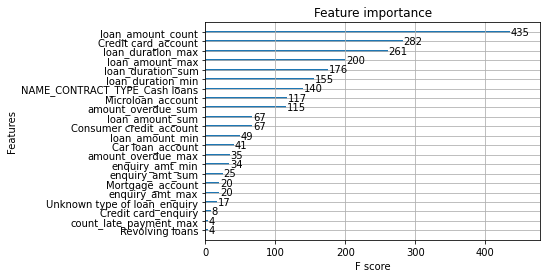

In [16]:
scale_pos_weight = sum(y_train == 0)/sum(y_train == 1) 
model = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
#model = XGBClassifier(scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
model.fit(X_train_encoded, y_train)

plot_importance(model)


In [18]:
y_pred_train = model.predict(X_train_encoded)
y_pred_train_prob = model.predict_proba(X_train_encoded)[:,1]
print('Train ')
performance(y_train,y_pred_train,y_pred_train_prob)
print('Test ')
X_test_encoded = std.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded,columns = X_test.columns)
y_pred_test = model.predict(X_test_encoded)
y_pred_test_prob = model.predict_proba(X_test_encoded)[:,1]
performance(y_test,y_pred_test,y_pred_test_prob)


Train 
f1 score  0.16286803867201158
Precision  0.09101235914213013
Recall  0.7737773313760333
Accuracy  0.474828731310926
ROC-AUC  0.6721713452764686
[[ 83069 100025]
 [  2928  10015]]
Test 
f1 score  0.1610016139286937
Precision  0.08999453253143794
Recall  0.7630968938340288
Accuracy  0.4749487344290393
ROC-AUC  0.666884274833853
[[27744 33288]
 [ 1022  3292]]


### On Complete Data

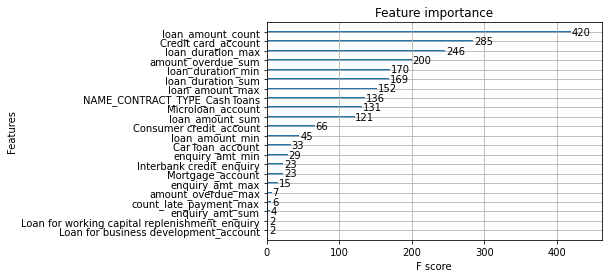

In [31]:
std_all = StandardScaler()
X_encoded = std_all.fit_transform(X)
X_encoded = pd.DataFrame(X_encoded,columns = X.columns)

scale_pos_weight = sum(y == 0)/sum(y == 1) 
model_all = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
#model = XGBClassifier(scale_pos_weight=round(scale_pos_weight),eval_metric = "auc")
model_all.fit(X_encoded, y)

plot_importance(model_all)

In [32]:
y_pred = model_all.predict(X_encoded)
y_pred_prob = model_all.predict_proba(X_encoded)[:,1]
performance(y,y_pred,y_pred_prob)

f1 score  0.16236207105614164
Precision  0.09066717225408476
Recall  0.7759170191806224
Accuracy  0.47142698645282977
ROC-AUC  0.6713185610364376
[[109833 134293]
 [  3867  13390]]


### Test Data Prediction

In [26]:
accounts_data_test['count_late_payment'] = accounts_data_test['payment_hist_string'].apply(count_bad_payment)

accounts_data_test['open_date'] = pd.to_datetime(accounts_data_test['open_date'])
accounts_data_test['closed_date'] = pd.to_datetime(accounts_data_test['closed_date'])

### Fill Null values : closed_date = open_date + payment_duration
accounts_data_test['closed_date'] = np.where(accounts_data_test['closed_date'].isna(),
                                              accounts_data_test[['open_date','payment_hist_string']].apply(lambda x: x[0] + pd.DateOffset(months=len(x[1])//3),axis=1),
                                              accounts_data_test['closed_date'])
accounts_data_test['loan_duration'] = (accounts_data_test['closed_date'] - accounts_data_test['open_date']).dt.days

### Make all credit type in columns and fill values with count of rows for each uid
credit_type_count_test = pd.crosstab(accounts_data_test['uid'],accounts_data_test['credit_type']).reset_index()
for col in credit_type_count.columns:
  if col not in credit_type_count_test.columns:
    credit_type_count_test[col] = 0
### UID level for amount variables
credit_amounts_test = accounts_data_test.groupby(['uid']).agg({'loan_amount':['sum','min','max','count'],
                                                     'amount_overdue':['sum','min','max','count'],
                                                     'count_late_payment':['sum','min','max','count'],
                                                     'loan_duration':['sum','min','max','count']}).reset_index()
credit_amounts_test.columns = credit_amounts_test.columns.map('_'.join)
credit_amounts_test.rename(columns={'uid_':'uid'},inplace=True)

for col in credit_amounts.columns:
  if col not in credit_amounts_test.columns:
    credit_amounts_test[col] = 0

uid_level_test = pd.merge(credit_type_count_test,credit_amounts_test,how='inner',on=['uid'])
### Merge with test_Flag
uid_level_test = pd.merge(uid_level_test,test_flag,how='inner',on=['uid'])
uid_level_test.fillna(0,inplace=True)
uid_level_test = pd.get_dummies(uid_level_test,columns=['NAME_CONTRACT_TYPE']) #Only categorcial column
uid_level_test.isna().sum().sum()

enquiry_type_count_test = pd.crosstab(enquiry_data_test['uid'],enquiry_data_test['enquiry_type']).reset_index()
enquiry_amt_test = enquiry_data_test.groupby(['uid']).agg({'enquiry_amt':['sum','min','max','count']}).reset_index()
enquiry_amt_test.columns = enquiry_amt_test.columns.map('_'.join)
enquiry_amt_test.rename(columns={'uid_':'uid'},inplace=True)
enquiry_test = pd.merge(enquiry_type_count_test,enquiry_amt_test,how='inner',on=['uid'])
enquiry_test.fillna(0,inplace=True)
enquiry_test.isna().sum().sum()

uid_level_test = pd.merge(uid_level_test,enquiry_test,how='right',on=['uid'],suffixes=('_account','_enquiry'))
uid_level_test.fillna(0,inplace=True)
uid_level_test.shape

In [39]:
X_test = uid_level_test.drop(columns=['uid'])
X_test = X_test[X.columns]
X_test_encoded = std_all.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded,columns = X_test.columns)

uid_level_test['pred_prob'] = model_all.predict_proba(X_test_encoded)[:,1]

In [43]:
sub = pd.merge(sub,uid_level_test[['uid','pred_prob']],how = 'left',on='uid')
sub['pred'] = sub['pred_prob']
sub[['uid','pred']].to_csv('senior_ds_test/data/final_submission/final_submission_Santanu_Datta.csv',index=0)